In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go
import os
from pydicom import dcmread
import scipy.ndimage

In [12]:
path = '../data/dicom/'
patients = os.listdir(path)
patients.sort()
patients

['PAT001', 'PAT002', 'PAT003', 'PAT004', 'PAT034']

In [13]:
def load_scan(path):
    slices = [dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)  
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices


def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)  
        
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [22]:
first_patient = load_scan(path + patients[1])
first_patient_pixels = get_pixels_hu(first_patient)
# image, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
image = first_patient_pixels
image.shape

(185, 512, 512)

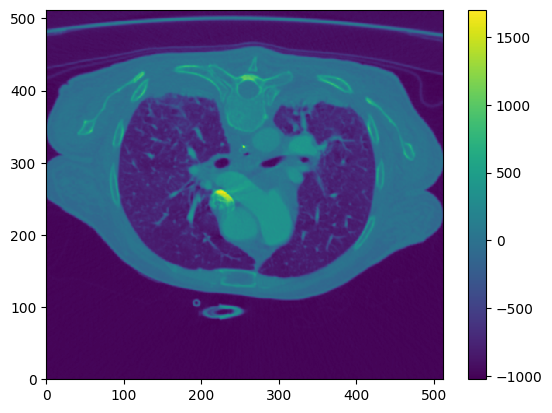

In [23]:
plt.pcolormesh(image[100])
plt.colorbar()